## Select the parameters for the experiment and log in the experiment folder

In [1]:
# %%writefile param_sets.json
seed_value = 123  # seed for the experiment
Trial = 2  # number of the experiment

period = 6  # the period to sample the data at. 1 period= 5 minutes

inputcols = ['oat', 'orh', 'sat-oat', 'wbt']  # input predictors
x_loc = [0, 1, 2, 3]  # vars we want to plot in detailed plot
outputcols = ['hwe']  # output targets
input_timesteps = 1  # number of timesteps for the input sequence
output_timesteps = 1  # number of timesteps for the output sequence

# Smoothing
smooth_data = True  # whether to smooth the data or not
order = 5  # order of the filer
T = 300  # sampling_period in seconds
fs = 1 / 300  # sample rate, Hz
cutoff = 0.0001  # desired cutoff frequency of the filter, Hz

# adjust out of phase data
adjust_lag = True  # whether to adjust the lag for certain columns
lag_columns = outputcols  # choose columns to adjust lag
data_lag = -1  # lag by how many periods: negative means shift column upwards

# aggregate data based on period
aggregate_data = True  # aggregate data or not
rolling_sum_target = ['hwe']  # create sum aggregate for these columns
rolling_mean_target = [
    'oat', 'orh', 'sat-oat', 'wbt',
]  # create mean aggregate for these columns

# create temporal batches of data: df2dflist
days, hours = 7, 0

# Values below which we consider as 0 output in hwe units is kBTU in period*5 mins
threshold = 0.5

# Custom way to create Training Data
startweek = 0  # start week; indicates how large training set is
data_weeks = 39  # Create a large initial block startweek-data_weeks weeks of training and testing data
end_week = -1
create_lag = 0  # Create further lags in the output
scaling = True  # Scale the input and output features
feature_range = (0, 1)  # Scaling range
reshaping = True  # reshape data according to (batch_size, time_steps, features)

# model configuration
modelconfig = {
    'lstm_hidden_units': 4,
    'lstm_no_layers': 0,
    'dense_hidden_units': 16,
    'dense_no_layers': 6,
    'retrain_from_layers': 3,
    'train_stateful': False,
    'test_stateful':False,
    'train_batchsize':32,
    'test_batchsize':1, # we are doing online prediction
    'train_epochs': 5000,
}

# wheter doing adaptive for fixed learning
adaptive_control = True  # whether we relearn or keep it fixed
path = '../results/' + outputcols[0] + '_model{}/'.format(
    Trial) + 'adaptive/' * adaptive_control + 'fixed/' * (1 - adaptive_control)
#!rm -rf ../results/lstm_hwe_trial8/adaptive

#model design considerations
modeldesigndone = False  # whether model will be reinitialized
initial_epoch = 0  # the start epoch number for the training

# These are automatically superseded and ignored if adaptive_control is set to False
retain_prev_model = True  # retain weights of model from previous training
freeze_model = True  # freeze weights of certain layers
reinitialize = True  # reinitialize the weights of certain layers

model_saved = False  # whether model has been saved once
test_model_created = False  # create an idectical model for online predicton

# data used for learning the model
datapath = '../data/processed/buildingdata.pkl'

# additional info
addl = {
    'metainfo': 'create a diff of sat and oat for hot water energy prediction as it is useful. See 1.0.8',
    'names_abreviation': {
        'oat':'Outside Air Temperature',
        'orh':'Outside Air Relative Humidity',
        'sat-oat' : 'Difference of Supply Air and Outside Air Temps ',
        'ghi': 'Global Solar Irradiance',
        'hw_sf':'Hot Water System Flow Rate',
        'hx_vlv1':'Hot Water Valve %',
        'hw_st':'Hot Water Supply Temperature',
        'hwe': 'Hot Water Energy Consumption',
        'wbt': 'Wet Builb Temperature',
    }
}
x_lab = [addl['names_abreviation'][inputcols[i]] for i in x_loc]

## Set Seed in numpy, Keras and TF for reproducability; Import modules; Set GPU configurations

In [2]:
import shutil
import glob
import os
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# Enable '0' or disable '-1' GPU use
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# including the project directory to the notebook level
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import json
from tqdm import tqdm
import parse
import warnings
from matplotlib.dates import date2num

In [3]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
    #tf.random.set_seed(seed_value)
    # for later versions: 
    tf.compat.v1.set_random_seed(seed_value)
    config = tf.ConfigProto(log_device_placement=False)
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    
    from keras import backend as K
    from nn_source import models as mp

from dataprocess import dataprocessor as dp
from dataprocess import plotutils as pu

Using TensorFlow backend.


In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir '../results/lstm_hwe_trial1/loginfo/' --port 8200

## Create Folder to save models and tensorboard logs

In [4]:
# create the results directory
try:
    os.makedirs(path)
except FileExistsError:
    files = os.listdir(path)
    for f in files:
        try:
            shutil.rmtree(path + f)
        except NotADirectoryError:
            os.remove(path + f)
        
os.mkdir(path + 'loginfo')
os.mkdir(path + 'normalplots')
os.mkdir(path + 'detailedplots')

## Save the experiment parameters and configurations

In [5]:
#save the values
paramsdict = {
    
    'seed_value' : seed_value,
    
    'period':period,
    
    'inputcols':inputcols,
    'x_loc': x_loc,
    'outputcols':outputcols,
    'input_timesteps':input_timesteps,
    'output_timesteps':output_timesteps,
    
    'smooth_data': smooth_data,
    'order' : 5,
    'T' : T,
    'fs' : fs,
    'cutoff' : cutoff,
    
    'adjust_lag' : adjust_lag,
    'lag_columns' : lag_columns,
    'data_lag' : data_lag,
    
    'aggregate_data' : aggregate_data,
    'rolling_sum_target' : rolling_sum_target,
    'rolling_mean_target' : rolling_mean_target,
    
    'days':days,
    'hours':hours,
    
    'threshold': threshold,
    
    'startweek': startweek,
    'data_weeks' : data_weeks,
    'threshold': threshold,
    'create_lag' : create_lag,
    'scaling' : scaling,
    'feature_range' : feature_range,
    'reshaping' : reshaping,
    
    'modelconfig' : modelconfig,
    
    'adaptive_control':adaptive_control,
    'path':path,
    
    'modeldesigndone' : modeldesigndone,
    'initial_epoch' : initial_epoch,
    
    'retain_prev_model' : retain_prev_model,
    'freeze_model' : freeze_model,
    'reinitialize' : reinitialize,
    'model_saved' : model_saved,
    'test_model_created': test_model_created,
    
    'datapath' : datapath,
    
    'addl' : addl,
}
    
# with open(path+'params.json', 'r') as fp:
#     param2dict = json.load(fp)

with open(path+'params.json', 'w') as fp:
    json.dump(paramsdict, fp, indent=4)

## Read the cleaned data

In [6]:
# read the pickled file for ahu data
df1data = dp.readfile(datapath)

# return pickled df
df1 = df1data.return_df(processmethods=['file2df'])

In [7]:
# read the pickled file for wet bulb data
df2data = dp.readfile('../data/processed/interpolated/wetbulbtemp.pkl')

# return pickled df
df2 = df2data.return_df(processmethods=['file2df'])

In [8]:
df = dp.merge_df_columns([df1,df2])

## Create additional Data columns as needed

In [9]:
df['sat-oat']= df['sat']-df['oat']

## Smooth the data

In [10]:
if smooth_data:
    df = dp.dfsmoothing(df=df,
                        column_names=list(df.columns),
                        order=order,
                        Wn=cutoff,
                        T=T)

## Remove <0 values for output energy

In [11]:
df['hwe'][df['hwe']<=0]=0.0

## Adjust lag for certain columns if needed

In [12]:
if adjust_lag:
    df = dp.createlag(df, lag_columns, lag=data_lag)

## Create aggregate data: aggregate specified columns at specified intervals

In [13]:
# return a new column which is the sum of previous window_size values
def window_sum(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).sum()

# return a new column which is the average of previous window_size values
def window_mean(df_, window_size: int, column_names: list):
    return df_[column_names].rolling(window=window_size, min_periods=window_size).mean()

# rolling_sum_output = ['{}min_{}_sum'.format(5*period,target) for target in rolling_sum_target]
# rolling_mean_output = ['{}min_{}_mean'.format(5*period,target) for target in rolling_mean_target]

if aggregate_data:
    
    # rolling sum
    if rolling_sum_target:
        df[rolling_sum_target] =  window_sum(df, window_size=period, column_names=rolling_sum_target)
    
    # rolling mean
    if rolling_mean_target:
        df[rolling_mean_target] =  window_mean(df, window_size=period, column_names=rolling_mean_target)
    
    df = dp.dropNaNrows(df)
    
    # Sample the data at period intervals
    df = dp.sample_timeseries_df(df, period=period)

In [14]:
# show data
df.describe()

,oat,sat,sat_stpt,orh,hwe,cwe,ghi,avg_stpt,flow,hw_rt,hw_sf,hw_st,hw_s_stp,hx_vlv1,wbt,sat-oat
count,21971.000000,21971.000000,21971.000000,21971.000000,2.197100e+04,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000,21971.000000
mean,63.626061,70.280306,71.526940,60.053565,2.059501e+01,22.961840,173.045241,71.544148,37.374449,91.823088,8.728783,101.228479,101.231408,25.100563,55.037507,6.653835
std,17.457382,5.648634,2.917083,17.336188,2.542404e+01,17.689552,258.519946,1.048642,30.586206,13.308474,9.455208,14.401975,14.225589,20.175748,14.713747,17.897679
min,17.638819,51.855114,58.595467,17.237653,-7.327472e-15,0.000000,0.000000,66.466667,0.000018,64.947403,-1.393096,77.685165,90.000000,0.000000,14.639024,-25.277482
25%,49.134224,67.439785,73.000000,46.691106,2.220446e-16,7.537702,0.000000,70.895238,10.094883,82.424969,0.000000,90.167656,90.000000,7.299322,42.726069,-6.364388
50%,65.847777,71.908134,73.000000,59.333333,1.177621e+01,21.089712,7.000000,71.342857,32.527981,87.479713,5.783177,94.486305,91.792168,23.971956,57.829886,2.635854
75%,77.797713,73.724075,73.000000,74.140239,2.934486e+01,38.203423,282.000000,72.485714,63.528797,98.615917,13.121335,112.237209,112.145386,43.579166,68.089480,23.609758
max,97.068787,88.511330,73.390434,96.000000,1.631912e+02,74.281441,965.000000,73.533333,128.265732,136.656403,31.659739,148.283646,148.433563,77.857613,86.812275,55.970702


## Get mean of the entire scaled data

In [15]:
# get the mean of the outputs for the entire data
dfscaled = ((df-df.min())/(df.max()-df.min()))
threshold_scaled = ((threshold-df.min()['hwe'])/(df.max()['hwe']-df.min()['hwe']))
dfscaled = dfscaled[dfscaled['hwe']>=threshold_scaled]
dfmean = dfscaled.mean() 
mean_output = list(dfmean[outputcols])
mean_input = list(dfmean[inputcols])

## Create temporal chunks of data

In [16]:
# Creating a list of "days" day dataframes for training
dflist = dp.df2dflist_alt(df[inputcols+outputcols],
                      subsequence=True,
                      period=period,
                      days=days,
                      hours=hours)
print('Length of dflist: {}'.format(len(dflist)))

Length of dflist: 76


## Custom way to create Training Data

In [17]:
assert (input_timesteps == 1) & (
    output_timesteps == 1), "Input and Output timesteps must be 1 for this notebook"

In [18]:
from pandas import concat
import swifter


def quickmerge(listdf):
    return concat(listdf)


def df2operating_regions(df, column_names, thresholds):
    """
    Select from data frame the operating regions based on threshold
    """
    
    org_shape = df.shape[0]
    
    # select cells to be retained
    constraints = df.swifter.apply(
        lambda row: all([(cell > thresholds) for cell in row[column_names]]),
        axis=1)
    # Drop values set to be rejected
    df = df.drop(df.index[~constraints], axis = 0)
    
    print("Retaining {}% of the data".format(100*df.shape[0]/org_shape))
    
    return df

weeklist = []  # create list of training, testing arrays

In [19]:
# select and merge data_weeks-1 worth of data
datablock_train_pre = dflist[startweek:data_weeks-1]
datablock_train = quickmerge(datablock_train_pre)
#Select from data frame the operating regions
datablock_train = df2operating_regions(datablock_train, outputcols, threshold)
"""
#divide into contiguous regions
datablock_train = dp.subsequencing(datablock_train, period=period)
#drop smaller blocks
datablock_train = [item for item in datablock_train if item.shape[0] >= 0.05*modelconfig['train_batchsize']]
#merge them together
minibatch_train = quickmerge(datablock_train)
"""
minibatch_train = datablock_train

# select weeks=1 worth of data
datablock_test_pre = dflist[data_weeks-1]
#Select from data frame the operating regions
datablock_test = df2operating_regions(datablock_test_pre, outputcols, threshold)
"""
#divide into contiguous operating region
datablock_test = dp.subsequencing(datablock_test_pre, period=period)
#drop smaller blocks
datablock_test = [item for item in datablock_test if item.shape[0] >= 0.05*modelconfig['test_batchsize']]
#merge them together
minibatch_test = quickmerge(datablock_test)
"""
minibatch_test = datablock_test


# splitvalue
splitvalue = minibatch_test.shape[0]
#merge test and train together
data_block = quickmerge([minibatch_train, minibatch_test])

# create numpy arrays
X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

# select test ids for later plots
test_idx = minibatch_test.index

# year and week
yearno = minibatch_test.index[int(splitvalue/2)].year
weekno = minibatch_test.index[int(splitvalue/2)].week

# append them
weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(yearno), 
                                      str(weekno)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })



Retaining 68.1501962183375% of the data



Retaining 60.43613707165109% of the data


In [20]:
for weekdata in dflist[data_weeks:end_week]:
    
    # select and merge data_weeks-1 worth of data
    datablock_train_pre = datablock_train_pre[1:]+[datablock_test_pre]
    datablock_train = quickmerge(datablock_train_pre)
    #Select from data frame the operating regions
    datablock_train = df2operating_regions(datablock_train, outputcols, threshold)
    minibatch_train = datablock_train
    
    # select weeks=1 worth of data
    datablock_test_pre = weekdata
    #Select from data frame the operating regions
    datablock_test = df2operating_regions(datablock_test_pre, outputcols, threshold)
    minibatch_test = datablock_test
    
    # splitvalue
    splitvalue = minibatch_test.shape[0]
    #merge test and train together
    data_block = quickmerge([minibatch_train, minibatch_test])

    # and add new week data from weekdata
    X_train, X_test, y_train, y_test, X_scaler, y_scaler = dp.df2arrays(
        data_block,
        predictorcols=inputcols,
        outputcols=outputcols,
        scaling=scaling,
        feature_range=feature_range,
        reshaping=reshaping,
        lag=create_lag,
        split=splitvalue,
    input_timesteps=input_timesteps,
    output_timesteps = output_timesteps
    )

    # select test ids for later plots
    test_idx = minibatch_test.index
    
    # year and week no
    weekno += 1
    weekno = weekno if weekno%53 != 0 else 1
    yearno = yearno if weekno!= 1 else yearno+1

    weeklist.append({
        'Id':'Year-{}-Week-{}'.format(str(yearno), 
                                      str(weekno)),
        'X_train':X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test,
        'y_scaler':y_scaler,
        'X_scaler':X_scaler,
        'test_idx':test_idx,
    })

print('Length of weeklist: {}'.format(len(weeklist)))


Retaining 69.82443632474823% of the data



Retaining 59.81012658227848% of the data



Retaining 70.26327532351628% of the data



Retaining 60.8974358974359% of the data



Retaining 70.41473006792992% of the data



Retaining 92.35668789808918% of the data



Retaining 71.70518425983761% of the data



Retaining 72.63843648208469% of the data



Retaining 71.91954525579362% of the data



Retaining 94.25287356321839% of the data



Retaining 72.63543715358483% of the data



Retaining 100.0% of the data



Retaining 72.72563013822386% of the data



Retaining 97.81021897810218% of the data



Retaining 72.91628334866606% of the data



Retaining 84.66257668711657% of the data



Retaining 73.76611418047882% of the data



Retaining 88.36477987421384% of the data



Retaining 73.75507192917742% of the data



Retaining 92.47648902821317% of the data



Retaining 74.12264499445881% of the data



Retaining 53.82262996941896% of the data



Retaining 73.02291204730228% of the data



Retaining 51.5527950310559% of the data



Retaining 73.08578273288492% of the data



Retaining 91.94029850746269% of the data



Retaining 74.30638219943229% of the data



Retaining 58.25825825825826% of the data



Retaining 73.91622462044997% of the data



Retaining 73.49397590361446% of the data



Retaining 74.58044509303174% of the data



Retaining 52.38095238095238% of the data



Retaining 73.31763427225795% of the data



Retaining 12.666666666666666% of the data



Retaining 72.65223771093177% of the data



Retaining 38.2262996941896% of the data



Retaining 71.55401079301198% of the data



Retaining 100.0% of the data



Retaining 72.01458523245215% of the data



Retaining 67.55952380952381% of the data



Retaining 71.55281753940932% of the data



Retaining 67.55952380952381% of the data



Retaining 71.42728175498782% of the data



Retaining 61.23076923076923% of the data



Retaining 70.70561797752809% of the data



Retaining 82.73809523809524% of the data



Retaining 71.10793168201735% of the data



Retaining 98.80597014925372% of the data



Retaining 72.12326327039544% of the data



Retaining 88.69047619047619% of the data



Retaining 73.10939305074203% of the data



Retaining 53.48101265822785% of the data



Retaining 72.14115149907137% of the data



Retaining 56.22895622895623% of the data



Retaining 71.31558133403638% of the data



Retaining 100.0% of the data



Retaining 71.37915742793791% of the data



Retaining 100.0% of the data



Retaining 71.51774567504904% of the data



Retaining 100.0% of the data



Retaining 70.90426505583012% of the data



Retaining 61.81818181818182% of the data



Retaining 70.44997256264863% of the data



Retaining 84.0625% of the data



Retaining 69.97804610318332% of the data



Retaining 68.359375% of the data



Retaining 70.39800995024876% of the data



Retaining 52.46478873239437% of the data



Retaining 70.10089789873183% of the data



Retaining 100.0% of the data



Retaining 71.47311726353585% of the data



Retaining 97.03947368421052% of the data
Length of weeklist: 37


## Print size and shape of data to feed to the model for sanity checks

In [21]:
for week in weeklist:
    for key,value in week.items():
        if (key != 'y_scaler') & (key != 'X_scaler') :
            print("name: {}, shape: {}".format(key, value.shape if not isinstance(value,str) else value))

name: Id, shape: Year-2019-Week-15
name: X_train, shape: (7641, 1, 4)
name: y_train, shape: (7641, 1, 1)
name: X_test, shape: (194, 1, 4)
name: y_test, shape: (194, 1, 1)
name: test_idx, shape: (194,)
name: Id, shape: Year-2019-Week-16
name: X_train, shape: (7835, 1, 4)
name: y_train, shape: (7835, 1, 1)
name: X_test, shape: (189, 1, 4)
name: y_test, shape: (189, 1, 1)
name: test_idx, shape: (189,)
name: Id, shape: Year-2019-Week-17
name: X_train, shape: (7873, 1, 4)
name: y_train, shape: (7873, 1, 1)
name: X_test, shape: (190, 1, 4)
name: y_test, shape: (190, 1, 1)
name: test_idx, shape: (190,)
name: Id, shape: Year-2019-Week-18
name: X_train, shape: (7878, 1, 4)
name: y_train, shape: (7878, 1, 1)
name: X_test, shape: (290, 1, 4)
name: y_test, shape: (290, 1, 1)
name: test_idx, shape: (290,)
name: Id, shape: Year-2019-Week-19
name: X_train, shape: (8036, 1, 4)
name: y_train, shape: (8036, 1, 1)
name: X_test, shape: (223, 1, 4)
name: y_test, shape: (223, 1, 1)
name: test_idx, shape: (2

## Add weekly train test data to modelconfig dictionary for ease of training

In [22]:
modelconfig['weeklist'] = weeklist

##  Clear the Tensorflow graph from previous training

In [23]:
K.clear_session()

## Inspect model architecture

In [ ]:
# weekdata = modelconfig['weeklist'][1]
# X_train = weekdata['X_train']
# y_train = weekdata['y_train']
# X_test = weekdata['X_test']
# y_test = weekdata['y_test']
# y_scaler = weekdata['y_scaler']

# #Instantiate learner model
# nn_model = mp.simple_LSTM_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()
# print(K.get_session())

# # nn_model.model.summary()0x7f8d2b89f048  0x7f8ba4767550>

# #Instantiate learner model
# nn_model2 = mp.simple_LSTM_model(path,
#                       inputdim=X_train.shape[-1],
#                       outputdim=y_train.shape[-1],
#                       period=period)

# # Desing model architecture
# nn_model2.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * (2*modelconfig['lstm_no_layers']),
#                    densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
#                    dropoutlist=[[], []],
#                    batchnormalizelist=[[], []])

# # compile model
# nn_model.model_compile()

# print(K.get_session())

## Train the model

In [24]:
for weekno, BatchData in enumerate(tqdm(modelconfig['weeklist'])):

    """Begin weekly training"""   
    X_train = BatchData['X_train']
    y_train = BatchData['y_train']

    K.clear_session()
    
    try:
        del nn_model
    except NameError:
        pass

    #Instantiate learner model
    nn_model = mp.simple_LSTM_model(path,
                                  inputdim=X_train.shape[-1],
                                  outputdim=y_train.shape[-1],
                                  input_timesteps=input_timesteps,
                                  output_timesteps = output_timesteps,
                                  period=period,
                                  stateful = modelconfig['train_stateful'],
                                  batch_size=modelconfig['train_batchsize'])

    # Desing model architecture
    nn_model.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])

    # load the trained model weights if we want to: here some layer weights may be reinitialized; see below
    if model_saved & retain_prev_model:
        nn_model.model.load_weights('IntermediateModel.h5')


    # compile model
    nn_model.model_compile()   

    # train the model for adaptive model and fixed after first round for fixed control
    if adaptive_control | (weekno==0):
        history = nn_model.train_model(X_train,
                                       y_train,
                                       epochs=modelconfig['train_epochs'],
                                       initial_epoch=initial_epoch)
        try:
            initial_epoch += len(history.history['loss'])
        except KeyError:
            pass

        # save the model only if trained at least once- needed for prediction model
        nn_model.model.save('IntermediateModel.h5')
        model_saved = True     
    """End Weekly Training"""
    
    
    """Begin Last Week Prediction"""
    
    y_scaler = BatchData['y_scaler']
    X_scaler = BatchData['X_scaler']
    X_test = BatchData['X_test']
    y_test = BatchData['y_test']
   

    try:
        del nn_model_pred
    except NameError:
        pass
    # K.clear_session()

    # Separate predictor for predicting online: only difference is test batch size
    nn_model_pred = mp.simple_LSTM_model(path,
                                       inputdim=X_test.shape[-1],
                                       outputdim=y_test.shape[-1],
                                       input_timesteps=input_timesteps,
                                       output_timesteps = output_timesteps,
                                       period=period,
                                       stateful = modelconfig['test_stateful'],
                                       batch_size=modelconfig['test_batchsize'])

    # Desing model architecture
    nn_model_pred.design_network(lstmhiddenlayers=[modelconfig['lstm_hidden_units']] * modelconfig['lstm_no_layers'],
                            densehiddenlayers=[modelconfig['dense_hidden_units']] * modelconfig['dense_no_layers'],
                            dropoutlist=[[], []],
                            batchnormalizelist=[[], []])


    # load the trained model weights
    nn_model_pred.model.load_weights('IntermediateModel.h5')
    # compile model
    nn_model_pred.model_compile()

    # evaluate the model for metrics at this stage
    # train and test plots as well as logged errors inside the text file
    preds_test = nn_model_pred.evaluate_model( X_test,
                                               y_test,
                                               y_scaler,
                                               save_plot_loc=path+'normalplots/',
                                               scaling=True,
                                               saveplot=True,
                                               Idx=BatchData['Id'],
                                               outputdim_names=[addl['names_abreviation'][outputcols[0]]],
                                               output_mean = mean_output)

    # do a detailed plot instead
    pu.detailedplot(period * 5,
                    xs = date2num(list(BatchData['test_idx'])),
                    outputdim=len(outputcols),
                    output_timesteps=output_timesteps,
                    input_timesteps=input_timesteps,
                    pred=preds_test,
                    target=y_test,
                    X_var=X_test,
                    x_loc=x_loc,
                    x_lab=x_lab,
                    saveloc=path + 'detailedplots/',
                    scaling=True,
                    Xscaler=X_scaler,
                    yscaler=y_scaler,
                    outputdim_names=[addl['names_abreviation'][outputcols[0]]],
                    typeofplot='test',
                    Idx=BatchData['Id'])
    """End Last Week Prediction"""

    """Only execute when we are freezing LSTM and just training on Dense"""
    if adaptive_control:
        
        # freeze all but dense layers at the top and compile with new weights
        if freeze_model:
            for layer in nn_model.model.layers[:modelconfig['retrain_from_layers']]:
                layer.trainable = False

        # for relearning, reinitialize top few layers
        if reinitialize:
            for layer in nn_model.model.layers[modelconfig['retrain_from_layers']:]:
                layer.kernel.initializer.run(session=K.get_session())
                layer.bias.initializer.run(session=K.get_session())

        # recompile model
        if freeze_model | reinitialize:
            nn_model.model_compile()
            
            # save the model- needed for Keras limitations: Tensorboard crashes if we relearn on original model with
            # reinitialized weights; solution: we create new model and load these weights
            nn_model.model.save('IntermediateModel.h5')
            model_saved = True
            
            freeze_model = False
            reinitialize = False

  0%|          | 0/37 [00:00<?, ?it/s]






Epoch 1/5000
 - 1s - loss: 0.0180
Epoch 2/5000
 - 1s - loss: 0.0137
Epoch 3/5000
 - 1s - loss: 0.0090
Epoch 4/5000
 - 1s - loss: 0.0075
Epoch 5/5000
 - 1s - loss: 0.0074
Epoch 6/5000
 - 1s - loss: 0.0073
Epoch 7/5000
 - 1s - loss: 0.0076
Epoch 8/5000
 - 1s - loss: 0.0072
Epoch 9/5000
 - 1s - loss: 0.0074
Epoch 10/5000
 - 1s - loss: 0.0074
Epoch 11/5000
 - 1s - loss: 0.0080
Epoch 12/5000
 - 1s - loss: 0.0064
Epoch 13/5000
 - 1s - loss: 0.0062
Epoch 14/5000
 - 1s - loss: 0.0061
Epoch 15/5000
 - 1s - loss: 0.0061
Epoch 16/5000
 - 1s - loss: 0.0060
Epoch 17/5000
 - 1s - loss: 0.0060
Epoch 18/5000
 - 1s - loss: 0.0060
Epoch 19/5000
 - 1s - loss: 0.0060
Epoch 20/5000
 - 1s - loss: 0.0060
Epoch 21/5000
 - 1s - loss: 0.0060
Epoch 22/5000
 - 1s - loss: 0.0060
Epoch 23/5000
 - 1s - loss: 0.0060
Epoch 24/5000
 - 1s - loss: 0.0060
Epoch 25/5000
 - 1s - loss: 0.0060
Epoch 26/5000
 - 1s - loss: 0.0060
Epoch 27/5000
 - 1s - loss: 0.0060
Epoch 28/5000
 - 1s - loss: 0.0060
Epoch 29/5000
 - 1s - lo

  3%|▎         | 1/37 [00:33<19:51, 33.10s/it]

Epoch 46/5000
 - 1s - loss: 0.0118
Epoch 47/5000
 - 1s - loss: 0.0086
Epoch 48/5000
 - 1s - loss: 0.0082
Epoch 49/5000
 - 1s - loss: 0.0076
Epoch 50/5000
 - 1s - loss: 0.0076
Epoch 51/5000
 - 1s - loss: 0.0072
Epoch 52/5000
 - 1s - loss: 0.0073
Epoch 53/5000
 - 1s - loss: 0.0071
Epoch 54/5000
 - 1s - loss: 0.0072
Epoch 55/5000
 - 1s - loss: 0.0071
Epoch 56/5000
 - 1s - loss: 0.0077
Epoch 57/5000
 - 1s - loss: 0.0064
Epoch 58/5000
 - 1s - loss: 0.0061
Epoch 59/5000
 - 1s - loss: 0.0061
Epoch 60/5000
 - 1s - loss: 0.0061
Epoch 61/5000
 - 1s - loss: 0.0060
Epoch 62/5000
 - 1s - loss: 0.0060
Epoch 63/5000
 - 1s - loss: 0.0060
Epoch 64/5000
 - 1s - loss: 0.0060
Epoch 65/5000
 - 1s - loss: 0.0060
Epoch 66/5000
 - 1s - loss: 0.0060
Epoch 67/5000
 - 1s - loss: 0.0060
Epoch 68/5000
 - 1s - loss: 0.0060
Epoch 69/5000
 - 1s - loss: 0.0060
Epoch 70/5000
 - 1s - loss: 0.0060
Epoch 71/5000
 - 1s - loss: 0.0060
Epoch 72/5000
 - 1s - loss: 0.0060
Epoch 73/5000
 - 1s - loss: 0.0060
Epoch 74/5000
 - 1s 

  5%|▌         | 2/37 [01:05<19:13, 32.95s/it]

Epoch 90/5000
 - 1s - loss: 0.0073
Epoch 91/5000
 - 1s - loss: 0.0072
Epoch 92/5000
 - 1s - loss: 0.0070
Epoch 93/5000
 - 1s - loss: 0.0069
Epoch 94/5000
 - 1s - loss: 0.0069
Epoch 95/5000
 - 1s - loss: 0.0068
Epoch 96/5000
 - 1s - loss: 0.0068
Epoch 97/5000
 - 1s - loss: 0.0075
Epoch 98/5000
 - 1s - loss: 0.0062
Epoch 99/5000
 - 1s - loss: 0.0060
Epoch 100/5000
 - 1s - loss: 0.0059
Epoch 101/5000
 - 1s - loss: 0.0059
Epoch 102/5000
 - 1s - loss: 0.0059
Epoch 103/5000
 - 1s - loss: 0.0059
Epoch 104/5000
 - 1s - loss: 0.0058
Epoch 105/5000
 - 1s - loss: 0.0058
Epoch 106/5000
 - 1s - loss: 0.0058
Epoch 107/5000
 - 1s - loss: 0.0058
Epoch 108/5000
 - 1s - loss: 0.0058
Epoch 109/5000
 - 1s - loss: 0.0058
Epoch 110/5000
 - 1s - loss: 0.0058
Epoch 111/5000
 - 1s - loss: 0.0058
Epoch 112/5000
 - 1s - loss: 0.0058
Epoch 113/5000
 - 1s - loss: 0.0058
Epoch 114/5000
 - 1s - loss: 0.0058
Epoch 115/5000
 - 1s - loss: 0.0058
Epoch 116/5000
 - 1s - loss: 0.0058
Epoch 117/5000
 - 1s - loss: 0.0058
Ep

  8%|▊         | 3/37 [01:34<17:58, 31.71s/it]

Epoch 128/5000
 - 1s - loss: 0.0066
Epoch 129/5000
 - 1s - loss: 0.0069
Epoch 130/5000
 - 1s - loss: 0.0068
Epoch 131/5000
 - 1s - loss: 0.0073
Epoch 132/5000
 - 1s - loss: 0.0061
Epoch 133/5000
 - 1s - loss: 0.0059
Epoch 134/5000
 - 1s - loss: 0.0059
Epoch 135/5000
 - 1s - loss: 0.0059
Epoch 136/5000
 - 1s - loss: 0.0058
Epoch 137/5000
 - 1s - loss: 0.0058
Epoch 138/5000
 - 1s - loss: 0.0058
Epoch 139/5000
 - 1s - loss: 0.0058
Epoch 140/5000
 - 1s - loss: 0.0058
Epoch 141/5000
 - 1s - loss: 0.0058
Epoch 142/5000
 - 1s - loss: 0.0058
Epoch 143/5000
 - 1s - loss: 0.0058
Epoch 144/5000
 - 1s - loss: 0.0058
Epoch 145/5000
 - 1s - loss: 0.0058
Epoch 146/5000
 - 1s - loss: 0.0058
Epoch 147/5000
 - 1s - loss: 0.0058
Epoch 148/5000
 - 1s - loss: 0.0058
Epoch 149/5000
 - 1s - loss: 0.0058
Epoch 150/5000
 - 1s - loss: 0.0058
Epoch 151/5000
 - 1s - loss: 0.0058
Epoch 152/5000
 - 1s - loss: 0.0058
Epoch 153/5000
 - 1s - loss: 0.0058
Epoch 154/5000
 - 1s - loss: 0.0058
Epoch 155/5000
 - 1s - loss:

 11%|█         | 4/37 [02:00<16:31, 30.03s/it]

Epoch 162/5000
 - 1s - loss: 0.0064
Epoch 163/5000
 - 1s - loss: 0.0066
Epoch 164/5000
 - 1s - loss: 0.0065
Epoch 165/5000
 - 1s - loss: 0.0069
Epoch 166/5000
 - 1s - loss: 0.0059
Epoch 167/5000
 - 1s - loss: 0.0058
Epoch 168/5000
 - 1s - loss: 0.0058
Epoch 169/5000
 - 1s - loss: 0.0058
Epoch 170/5000
 - 1s - loss: 0.0057
Epoch 171/5000
 - 1s - loss: 0.0057
Epoch 172/5000
 - 1s - loss: 0.0057
Epoch 173/5000
 - 1s - loss: 0.0057
Epoch 174/5000
 - 1s - loss: 0.0057
Epoch 175/5000
 - 1s - loss: 0.0057
Epoch 176/5000
 - 1s - loss: 0.0057
Epoch 177/5000
 - 1s - loss: 0.0057
Epoch 178/5000
 - 1s - loss: 0.0057
Epoch 179/5000
 - 1s - loss: 0.0057
Epoch 180/5000
 - 1s - loss: 0.0057
Epoch 181/5000
 - 1s - loss: 0.0057
Epoch 182/5000
 - 1s - loss: 0.0057
Epoch 183/5000
 - 1s - loss: 0.0057
Epoch 184/5000
 - 1s - loss: 0.0057
Epoch 185/5000
 - 1s - loss: 0.0057
Epoch 186/5000
 - 1s - loss: 0.0057
Epoch 187/5000
 - 1s - loss: 0.0057
Epoch 188/5000
 - 1s - loss: 0.0057
Epoch 189/5000
 - 1s - loss:

 14%|█▎        | 5/37 [02:27<15:35, 29.23s/it]

Epoch 197/5000
 - 1s - loss: 0.0063
Epoch 198/5000
 - 1s - loss: 0.0063
Epoch 199/5000
 - 1s - loss: 0.0063
Epoch 200/5000
 - 1s - loss: 0.0066
Epoch 201/5000
 - 1s - loss: 0.0058
Epoch 202/5000
 - 1s - loss: 0.0057
Epoch 203/5000
 - 1s - loss: 0.0056
Epoch 204/5000
 - 1s - loss: 0.0056
Epoch 205/5000
 - 1s - loss: 0.0056
Epoch 206/5000
 - 1s - loss: 0.0056
Epoch 207/5000
 - 1s - loss: 0.0056
Epoch 208/5000
 - 1s - loss: 0.0056
Epoch 209/5000
 - 1s - loss: 0.0056
Epoch 210/5000
 - 1s - loss: 0.0055
Epoch 211/5000
 - 1s - loss: 0.0055
Epoch 212/5000
 - 1s - loss: 0.0055
Epoch 213/5000
 - 1s - loss: 0.0055
Epoch 214/5000
 - 1s - loss: 0.0055
Epoch 215/5000
 - 1s - loss: 0.0055
Epoch 216/5000
 - 1s - loss: 0.0055
Epoch 217/5000
 - 1s - loss: 0.0055
Epoch 218/5000
 - 1s - loss: 0.0055
Epoch 219/5000
 - 1s - loss: 0.0055
Epoch 220/5000
 - 1s - loss: 0.0055
Epoch 221/5000
 - 1s - loss: 0.0055
Epoch 222/5000
 - 1s - loss: 0.0055
Epoch 223/5000
 - 1s - loss: 0.0055
Epoch 224/5000
 - 1s - loss:

 16%|█▌        | 6/37 [02:55<14:52, 28.78s/it]

Epoch 232/5000
 - 1s - loss: 0.0062
Epoch 233/5000
 - 1s - loss: 0.0064
Epoch 234/5000
 - 1s - loss: 0.0063
Epoch 235/5000
 - 1s - loss: 0.0068
Epoch 236/5000
 - 1s - loss: 0.0058
Epoch 237/5000
 - 1s - loss: 0.0057
Epoch 238/5000
 - 1s - loss: 0.0057
Epoch 239/5000
 - 1s - loss: 0.0057
Epoch 240/5000
 - 1s - loss: 0.0057
Epoch 241/5000
 - 1s - loss: 0.0056
Epoch 242/5000
 - 1s - loss: 0.0056
Epoch 243/5000
 - 1s - loss: 0.0056
Epoch 244/5000
 - 1s - loss: 0.0056
Epoch 245/5000
 - 1s - loss: 0.0056
Epoch 246/5000
 - 1s - loss: 0.0056
Epoch 247/5000
 - 1s - loss: 0.0056
Epoch 248/5000
 - 1s - loss: 0.0056
Epoch 249/5000
 - 1s - loss: 0.0056
Epoch 250/5000
 - 1s - loss: 0.0056
Epoch 251/5000
 - 1s - loss: 0.0056
Epoch 252/5000
 - 1s - loss: 0.0056
Epoch 253/5000
 - 1s - loss: 0.0056
Epoch 254/5000
 - 1s - loss: 0.0056
Epoch 255/5000
 - 1s - loss: 0.0056
Epoch 256/5000
 - 1s - loss: 0.0056
Epoch 257/5000
 - 1s - loss: 0.0056
Epoch 258/5000
 - 1s - loss: 0.0056
Epoch 259/5000
 - 1s - loss:

 19%|█▉        | 7/37 [03:25<14:31, 29.04s/it]

Epoch 270/5000
 - 1s - loss: 0.0063
Epoch 271/5000
 - 1s - loss: 0.0064
Epoch 272/5000
 - 1s - loss: 0.0064
Epoch 273/5000
 - 1s - loss: 0.0066
Epoch 274/5000
 - 1s - loss: 0.0058
Epoch 275/5000
 - 1s - loss: 0.0058
Epoch 276/5000
 - 1s - loss: 0.0057
Epoch 277/5000
 - 1s - loss: 0.0057
Epoch 278/5000
 - 1s - loss: 0.0057
Epoch 279/5000
 - 1s - loss: 0.0057
Epoch 280/5000
 - 1s - loss: 0.0057
Epoch 281/5000
 - 1s - loss: 0.0057
Epoch 282/5000
 - 1s - loss: 0.0057
Epoch 283/5000
 - 1s - loss: 0.0056
Epoch 284/5000
 - 1s - loss: 0.0056
Epoch 285/5000
 - 1s - loss: 0.0056
Epoch 286/5000
 - 1s - loss: 0.0056
Epoch 287/5000
 - 1s - loss: 0.0056
Epoch 288/5000
 - 1s - loss: 0.0056
Epoch 289/5000
 - 1s - loss: 0.0056
Epoch 290/5000
 - 1s - loss: 0.0056
Epoch 291/5000
 - 1s - loss: 0.0056
Epoch 292/5000
 - 1s - loss: 0.0056
Epoch 293/5000
 - 1s - loss: 0.0056
Epoch 294/5000
 - 1s - loss: 0.0056
Epoch 295/5000
 - 1s - loss: 0.0056
Epoch 296/5000
 - 1s - loss: 0.0056
Epoch 297/5000
 - 1s - loss:

 22%|██▏       | 8/37 [03:52<13:47, 28.52s/it]

Epoch 305/5000
 - 1s - loss: 0.0064
Epoch 306/5000
 - 1s - loss: 0.0064
Epoch 307/5000
 - 1s - loss: 0.0064
Epoch 308/5000
 - 1s - loss: 0.0066
Epoch 309/5000
 - 1s - loss: 0.0059
Epoch 310/5000
 - 1s - loss: 0.0058
Epoch 311/5000
 - 1s - loss: 0.0058
Epoch 312/5000
 - 1s - loss: 0.0058
Epoch 313/5000
 - 1s - loss: 0.0058
Epoch 314/5000
 - 1s - loss: 0.0057
Epoch 315/5000
 - 1s - loss: 0.0057
Epoch 316/5000
 - 1s - loss: 0.0057
Epoch 317/5000
 - 1s - loss: 0.0057
Epoch 318/5000
 - 1s - loss: 0.0057
Epoch 319/5000
 - 1s - loss: 0.0057
Epoch 320/5000
 - 1s - loss: 0.0057
Epoch 321/5000
 - 1s - loss: 0.0057
Epoch 322/5000
 - 1s - loss: 0.0057
Epoch 323/5000
 - 1s - loss: 0.0057
Epoch 324/5000
 - 1s - loss: 0.0057
Epoch 325/5000
 - 1s - loss: 0.0057
Epoch 326/5000
 - 1s - loss: 0.0057
Epoch 327/5000
 - 1s - loss: 0.0057
Epoch 328/5000
 - 1s - loss: 0.0057
Epoch 329/5000
 - 1s - loss: 0.0057
Epoch 330/5000
 - 1s - loss: 0.0057
Epoch 331/5000
 - 1s - loss: 0.0057
Epoch 332/5000
 - 1s - loss:

 24%|██▍       | 9/37 [04:17<12:51, 27.54s/it]

Epoch 338/5000
 - 1s - loss: 0.0064
Epoch 339/5000
 - 1s - loss: 0.0063
Epoch 340/5000
 - 1s - loss: 0.0063
Epoch 341/5000
 - 1s - loss: 0.0064
Epoch 342/5000
 - 1s - loss: 0.0058
Epoch 343/5000
 - 1s - loss: 0.0058
Epoch 344/5000
 - 1s - loss: 0.0057
Epoch 345/5000
 - 1s - loss: 0.0057
Epoch 346/5000
 - 1s - loss: 0.0057
Epoch 347/5000
 - 1s - loss: 0.0057
Epoch 348/5000
 - 1s - loss: 0.0057
Epoch 349/5000
 - 1s - loss: 0.0057
Epoch 350/5000
 - 1s - loss: 0.0057
Epoch 351/5000
 - 1s - loss: 0.0057
Epoch 352/5000
 - 1s - loss: 0.0057
Epoch 353/5000
 - 1s - loss: 0.0057
Epoch 354/5000
 - 1s - loss: 0.0057
Epoch 355/5000
 - 1s - loss: 0.0057
Epoch 356/5000
 - 1s - loss: 0.0057
Epoch 357/5000
 - 1s - loss: 0.0057
Epoch 358/5000
 - 1s - loss: 0.0057
Epoch 359/5000
 - 1s - loss: 0.0057
Epoch 360/5000
 - 1s - loss: 0.0057
Epoch 361/5000
 - 1s - loss: 0.0057
Epoch 362/5000
 - 1s - loss: 0.0057
Epoch 363/5000
 - 1s - loss: 0.0057
Epoch 364/5000
 - 1s - loss: 0.0057
Epoch 365/5000
 - 1s - loss:

 27%|██▋       | 10/37 [04:46<12:35, 27.97s/it]

Epoch 375/5000
 - 1s - loss: 0.0062
Epoch 376/5000
 - 1s - loss: 0.0063
Epoch 377/5000
 - 1s - loss: 0.0063
Epoch 378/5000
 - 1s - loss: 0.0064
Epoch 379/5000
 - 1s - loss: 0.0058
Epoch 380/5000
 - 1s - loss: 0.0058
Epoch 381/5000
 - 1s - loss: 0.0057
Epoch 382/5000
 - 1s - loss: 0.0057
Epoch 383/5000
 - 1s - loss: 0.0057
Epoch 384/5000
 - 1s - loss: 0.0057
Epoch 385/5000
 - 1s - loss: 0.0057
Epoch 386/5000
 - 1s - loss: 0.0057
Epoch 387/5000
 - 1s - loss: 0.0057
Epoch 388/5000
 - 1s - loss: 0.0057
Epoch 389/5000
 - 1s - loss: 0.0057
Epoch 390/5000
 - 1s - loss: 0.0057
Epoch 391/5000
 - 1s - loss: 0.0057
Epoch 392/5000
 - 1s - loss: 0.0057
Epoch 393/5000
 - 1s - loss: 0.0057
Epoch 394/5000
 - 1s - loss: 0.0056
Epoch 395/5000
 - 1s - loss: 0.0056
Epoch 396/5000
 - 1s - loss: 0.0056
Epoch 397/5000
 - 1s - loss: 0.0056
Epoch 398/5000
 - 1s - loss: 0.0056
Epoch 399/5000
 - 1s - loss: 0.0056
Epoch 400/5000
 - 1s - loss: 0.0056
Epoch 401/5000
 - 1s - loss: 0.0056
Epoch 402/5000
 - 1s - loss:

 30%|██▉       | 11/37 [05:12<11:50, 27.31s/it]

Epoch 408/5000
 - 1s - loss: 0.0062
Epoch 409/5000
 - 1s - loss: 0.0062
Epoch 410/5000
 - 1s - loss: 0.0063
Epoch 411/5000
 - 1s - loss: 0.0064
Epoch 412/5000
 - 1s - loss: 0.0058
Epoch 413/5000
 - 1s - loss: 0.0057
Epoch 414/5000
 - 1s - loss: 0.0057
Epoch 415/5000
 - 1s - loss: 0.0056
Epoch 416/5000
 - 1s - loss: 0.0056
Epoch 417/5000
 - 1s - loss: 0.0056
Epoch 418/5000
 - 1s - loss: 0.0056
Epoch 419/5000
 - 1s - loss: 0.0056
Epoch 420/5000
 - 1s - loss: 0.0056
Epoch 421/5000
 - 1s - loss: 0.0056
Epoch 422/5000
 - 1s - loss: 0.0056
Epoch 423/5000
 - 1s - loss: 0.0056
Epoch 424/5000
 - 1s - loss: 0.0056
Epoch 425/5000
 - 1s - loss: 0.0056
Epoch 426/5000
 - 1s - loss: 0.0056
Epoch 427/5000
 - 1s - loss: 0.0056
Epoch 428/5000
 - 1s - loss: 0.0056
Epoch 429/5000
 - 1s - loss: 0.0056
Epoch 430/5000
 - 1s - loss: 0.0056
Epoch 431/5000
 - 1s - loss: 0.0056
Epoch 432/5000
 - 1s - loss: 0.0056
Epoch 433/5000
 - 1s - loss: 0.0056
Epoch 434/5000
 - 1s - loss: 0.0056
Epoch 435/5000
 - 1s - loss:

 32%|███▏      | 12/37 [05:40<11:24, 27.36s/it]

Epoch 444/5000
 - 1s - loss: 0.0062
Epoch 445/5000
 - 1s - loss: 0.0062
Epoch 446/5000
 - 1s - loss: 0.0062
Epoch 447/5000
 - 1s - loss: 0.0065
Epoch 448/5000
 - 1s - loss: 0.0059
Epoch 449/5000
 - 1s - loss: 0.0058
Epoch 450/5000
 - 1s - loss: 0.0058
Epoch 451/5000
 - 1s - loss: 0.0057
Epoch 452/5000
 - 1s - loss: 0.0057
Epoch 453/5000
 - 1s - loss: 0.0057
Epoch 454/5000
 - 1s - loss: 0.0057
Epoch 455/5000
 - 1s - loss: 0.0057
Epoch 456/5000
 - 1s - loss: 0.0057
Epoch 457/5000
 - 1s - loss: 0.0057
Epoch 458/5000
 - 1s - loss: 0.0057
Epoch 459/5000
 - 1s - loss: 0.0057
Epoch 460/5000
 - 1s - loss: 0.0057
Epoch 461/5000
 - 1s - loss: 0.0057
Epoch 462/5000
 - 1s - loss: 0.0057
Epoch 463/5000
 - 1s - loss: 0.0057
Epoch 464/5000
 - 1s - loss: 0.0057
Epoch 465/5000
 - 1s - loss: 0.0057
Epoch 466/5000
 - 1s - loss: 0.0057
Epoch 467/5000
 - 1s - loss: 0.0057
Epoch 468/5000
 - 1s - loss: 0.0057
Epoch 469/5000
 - 1s - loss: 0.0057
Epoch 470/5000
 - 1s - loss: 0.0057
Epoch 471/5000
 - 1s - loss:

 35%|███▌      | 13/37 [06:08<11:02, 27.62s/it]

Epoch 481/5000
 - 1s - loss: 0.0061
Epoch 482/5000
 - 1s - loss: 0.0061
Epoch 483/5000
 - 1s - loss: 0.0061
Epoch 484/5000
 - 1s - loss: 0.0064
Epoch 485/5000
 - 1s - loss: 0.0057
Epoch 486/5000
 - 1s - loss: 0.0057
Epoch 487/5000
 - 1s - loss: 0.0057
Epoch 488/5000
 - 1s - loss: 0.0056
Epoch 489/5000
 - 1s - loss: 0.0056
Epoch 490/5000
 - 1s - loss: 0.0056
Epoch 491/5000
 - 1s - loss: 0.0056
Epoch 492/5000
 - 1s - loss: 0.0056
Epoch 493/5000
 - 1s - loss: 0.0056
Epoch 494/5000
 - 1s - loss: 0.0056
Epoch 495/5000
 - 1s - loss: 0.0056
Epoch 496/5000
 - 1s - loss: 0.0056
Epoch 497/5000
 - 1s - loss: 0.0056
Epoch 498/5000
 - 1s - loss: 0.0056
Epoch 499/5000
 - 1s - loss: 0.0056
Epoch 500/5000
 - 1s - loss: 0.0056
Epoch 501/5000
 - 1s - loss: 0.0056
Epoch 502/5000
 - 1s - loss: 0.0056
Epoch 503/5000
 - 1s - loss: 0.0056
Epoch 504/5000
 - 1s - loss: 0.0056
Epoch 505/5000
 - 1s - loss: 0.0056
Epoch 506/5000
 - 1s - loss: 0.0056
Epoch 507/5000
 - 1s - loss: 0.0056
Epoch 508/5000
 - 1s - loss:

 38%|███▊      | 14/37 [06:34<10:24, 27.14s/it]

Epoch 515/5000
 - 1s - loss: 0.0059
Epoch 516/5000
 - 1s - loss: 0.0060
Epoch 517/5000
 - 1s - loss: 0.0060
Epoch 518/5000
 - 1s - loss: 0.0063
Epoch 519/5000
 - 1s - loss: 0.0055
Epoch 520/5000
 - 1s - loss: 0.0055
Epoch 521/5000
 - 1s - loss: 0.0055
Epoch 522/5000
 - 1s - loss: 0.0055
Epoch 523/5000
 - 1s - loss: 0.0054
Epoch 524/5000
 - 1s - loss: 0.0054
Epoch 525/5000
 - 1s - loss: 0.0054
Epoch 526/5000
 - 1s - loss: 0.0054
Epoch 527/5000
 - 1s - loss: 0.0054
Epoch 528/5000
 - 1s - loss: 0.0054
Epoch 529/5000
 - 1s - loss: 0.0054
Epoch 530/5000
 - 1s - loss: 0.0054
Epoch 531/5000
 - 1s - loss: 0.0054
Epoch 532/5000
 - 1s - loss: 0.0054
Epoch 533/5000
 - 1s - loss: 0.0054
Epoch 534/5000
 - 1s - loss: 0.0054
Epoch 535/5000
 - 1s - loss: 0.0054
Epoch 536/5000
 - 1s - loss: 0.0054
Epoch 537/5000
 - 1s - loss: 0.0054
Epoch 538/5000
 - 1s - loss: 0.0054
Epoch 539/5000
 - 1s - loss: 0.0054
Epoch 540/5000
 - 1s - loss: 0.0054
Epoch 541/5000
 - 1s - loss: 0.0054
Epoch 542/5000
 - 1s - loss:

 41%|████      | 15/37 [07:01<09:56, 27.10s/it]

Epoch 549/5000
 - 1s - loss: 0.0058
Epoch 550/5000
 - 1s - loss: 0.0060
Epoch 551/5000
 - 1s - loss: 0.0061
Epoch 552/5000
 - 1s - loss: 0.0062
Epoch 553/5000
 - 1s - loss: 0.0055
Epoch 554/5000
 - 1s - loss: 0.0055
Epoch 555/5000
 - 1s - loss: 0.0055
Epoch 556/5000
 - 1s - loss: 0.0054
Epoch 557/5000
 - 1s - loss: 0.0054
Epoch 558/5000
 - 1s - loss: 0.0054
Epoch 559/5000
 - 1s - loss: 0.0054
Epoch 560/5000
 - 1s - loss: 0.0054
Epoch 561/5000
 - 1s - loss: 0.0054
Epoch 562/5000
 - 1s - loss: 0.0054
Epoch 563/5000
 - 1s - loss: 0.0054
Epoch 564/5000
 - 1s - loss: 0.0054
Epoch 565/5000
 - 1s - loss: 0.0054
Epoch 566/5000
 - 1s - loss: 0.0054
Epoch 567/5000
 - 1s - loss: 0.0054
Epoch 568/5000
 - 1s - loss: 0.0054
Epoch 569/5000
 - 1s - loss: 0.0054
Epoch 570/5000
 - 1s - loss: 0.0054
Epoch 571/5000
 - 1s - loss: 0.0054
Epoch 572/5000
 - 1s - loss: 0.0054
Epoch 573/5000
 - 1s - loss: 0.0054
Epoch 574/5000
 - 1s - loss: 0.0054
Epoch 575/5000
 - 1s - loss: 0.0054
Epoch 576/5000
 - 1s - loss:

 43%|████▎     | 16/37 [07:30<09:38, 27.57s/it]

Epoch 586/5000
 - 1s - loss: 0.0057
Epoch 587/5000
 - 1s - loss: 0.0058
Epoch 588/5000
 - 1s - loss: 0.0059
Epoch 589/5000
 - 1s - loss: 0.0060
Epoch 590/5000
 - 1s - loss: 0.0054
Epoch 591/5000
 - 1s - loss: 0.0053
Epoch 592/5000
 - 1s - loss: 0.0053
Epoch 593/5000
 - 1s - loss: 0.0053
Epoch 594/5000
 - 1s - loss: 0.0053
Epoch 595/5000
 - 1s - loss: 0.0053
Epoch 596/5000
 - 1s - loss: 0.0052
Epoch 597/5000
 - 1s - loss: 0.0052
Epoch 598/5000
 - 1s - loss: 0.0052
Epoch 599/5000
 - 1s - loss: 0.0052
Epoch 600/5000
 - 1s - loss: 0.0052
Epoch 601/5000
 - 1s - loss: 0.0052
Epoch 602/5000
 - 1s - loss: 0.0052
Epoch 603/5000
 - 1s - loss: 0.0052
Epoch 604/5000
 - 1s - loss: 0.0052
Epoch 605/5000
 - 1s - loss: 0.0052
Epoch 606/5000
 - 1s - loss: 0.0052
Epoch 607/5000
 - 1s - loss: 0.0052
Epoch 608/5000
 - 1s - loss: 0.0052
Epoch 609/5000
 - 1s - loss: 0.0052
Epoch 610/5000
 - 1s - loss: 0.0052
Epoch 611/5000
 - 1s - loss: 0.0052
Epoch 612/5000
 - 1s - loss: 0.0052
Epoch 613/5000
 - 1s - loss:

 46%|████▌     | 17/37 [07:58<09:15, 27.77s/it]

Epoch 622/5000
 - 1s - loss: 0.0055
Epoch 623/5000
 - 1s - loss: 0.0057
Epoch 624/5000
 - 1s - loss: 0.0057
Epoch 625/5000
 - 1s - loss: 0.0058
Epoch 626/5000
 - 1s - loss: 0.0053
Epoch 627/5000
 - 1s - loss: 0.0052
Epoch 628/5000
 - 1s - loss: 0.0052
Epoch 629/5000
 - 1s - loss: 0.0052
Epoch 630/5000
 - 1s - loss: 0.0052
Epoch 631/5000
 - 1s - loss: 0.0051
Epoch 632/5000
 - 1s - loss: 0.0051
Epoch 633/5000
 - 1s - loss: 0.0051
Epoch 634/5000
 - 1s - loss: 0.0051
Epoch 635/5000
 - 1s - loss: 0.0051
Epoch 636/5000
 - 1s - loss: 0.0051
Epoch 637/5000
 - 1s - loss: 0.0051
Epoch 638/5000
 - 1s - loss: 0.0051
Epoch 639/5000
 - 1s - loss: 0.0051
Epoch 640/5000
 - 1s - loss: 0.0051
Epoch 641/5000
 - 1s - loss: 0.0051
Epoch 642/5000
 - 1s - loss: 0.0051
Epoch 643/5000
 - 1s - loss: 0.0051
Epoch 644/5000
 - 1s - loss: 0.0051
Epoch 645/5000
 - 1s - loss: 0.0051
Epoch 646/5000
 - 1s - loss: 0.0051
Epoch 647/5000
 - 1s - loss: 0.0051
Epoch 648/5000
 - 1s - loss: 0.0051
Epoch 649/5000
 - 1s - loss:

 49%|████▊     | 18/37 [08:24<08:36, 27.21s/it]

Epoch 655/5000
 - 1s - loss: 0.0053
Epoch 656/5000
 - 1s - loss: 0.0056
Epoch 657/5000
 - 1s - loss: 0.0056
Epoch 658/5000
 - 1s - loss: 0.0057
Epoch 659/5000
 - 1s - loss: 0.0052
Epoch 660/5000
 - 1s - loss: 0.0051
Epoch 661/5000
 - 1s - loss: 0.0051
Epoch 662/5000
 - 1s - loss: 0.0051
Epoch 663/5000
 - 1s - loss: 0.0051
Epoch 664/5000
 - 1s - loss: 0.0051
Epoch 665/5000
 - 1s - loss: 0.0050
Epoch 666/5000
 - 1s - loss: 0.0050
Epoch 667/5000
 - 1s - loss: 0.0050
Epoch 668/5000
 - 1s - loss: 0.0050
Epoch 669/5000
 - 1s - loss: 0.0050
Epoch 670/5000
 - 1s - loss: 0.0050
Epoch 671/5000
 - 1s - loss: 0.0050
Epoch 672/5000
 - 1s - loss: 0.0050
Epoch 673/5000
 - 1s - loss: 0.0050
Epoch 674/5000
 - 1s - loss: 0.0050
Epoch 675/5000
 - 1s - loss: 0.0050
Epoch 676/5000
 - 1s - loss: 0.0050
Epoch 677/5000
 - 1s - loss: 0.0050
Epoch 678/5000
 - 1s - loss: 0.0050
Epoch 679/5000
 - 1s - loss: 0.0050
Epoch 680/5000
 - 1s - loss: 0.0050
Epoch 681/5000
 - 1s - loss: 0.0050
Epoch 682/5000
 - 1s - loss:

 51%|█████▏    | 19/37 [08:50<08:04, 26.92s/it]

Epoch 689/5000
 - 1s - loss: 0.0052
Epoch 690/5000
 - 1s - loss: 0.0055
Epoch 691/5000
 - 1s - loss: 0.0055
Epoch 692/5000
 - 1s - loss: 0.0055
Epoch 693/5000
 - 1s - loss: 0.0049
Epoch 694/5000
 - 1s - loss: 0.0049
Epoch 695/5000
 - 1s - loss: 0.0049
Epoch 696/5000
 - 1s - loss: 0.0049
Epoch 697/5000
 - 1s - loss: 0.0048
Epoch 698/5000
 - 1s - loss: 0.0048
Epoch 699/5000
 - 1s - loss: 0.0048
Epoch 700/5000
 - 1s - loss: 0.0048
Epoch 701/5000
 - 1s - loss: 0.0048
Epoch 702/5000
 - 1s - loss: 0.0048
Epoch 703/5000
 - 1s - loss: 0.0048
Epoch 704/5000
 - 1s - loss: 0.0048
Epoch 705/5000
 - 1s - loss: 0.0048
Epoch 706/5000
 - 1s - loss: 0.0048
Epoch 707/5000
 - 1s - loss: 0.0048
Epoch 708/5000
 - 1s - loss: 0.0048
Epoch 709/5000
 - 1s - loss: 0.0048
Epoch 710/5000
 - 1s - loss: 0.0048
Epoch 711/5000
 - 1s - loss: 0.0048
Epoch 712/5000
 - 1s - loss: 0.0048
Epoch 713/5000
 - 1s - loss: 0.0048
Epoch 714/5000
 - 1s - loss: 0.0048
Epoch 715/5000
 - 1s - loss: 0.0048
Epoch 716/5000
 - 1s - loss:

 54%|█████▍    | 20/37 [09:18<07:42, 27.18s/it]

Epoch 726/5000
 - 1s - loss: 0.0050
Epoch 727/5000
 - 1s - loss: 0.0053
Epoch 728/5000
 - 1s - loss: 0.0053
Epoch 729/5000
 - 1s - loss: 0.0053
Epoch 730/5000
 - 1s - loss: 0.0048
Epoch 731/5000
 - 1s - loss: 0.0047
Epoch 732/5000
 - 1s - loss: 0.0047
Epoch 733/5000
 - 1s - loss: 0.0047
Epoch 734/5000
 - 1s - loss: 0.0047
Epoch 735/5000
 - 1s - loss: 0.0046
Epoch 736/5000
 - 1s - loss: 0.0046
Epoch 737/5000
 - 1s - loss: 0.0046
Epoch 738/5000
 - 1s - loss: 0.0046
Epoch 739/5000
 - 1s - loss: 0.0046
Epoch 740/5000
 - 1s - loss: 0.0046
Epoch 741/5000
 - 1s - loss: 0.0046
Epoch 742/5000
 - 1s - loss: 0.0046
Epoch 743/5000
 - 1s - loss: 0.0046
Epoch 744/5000
 - 1s - loss: 0.0046
Epoch 745/5000
 - 1s - loss: 0.0046
Epoch 746/5000
 - 1s - loss: 0.0046
Epoch 747/5000
 - 1s - loss: 0.0046
Epoch 748/5000
 - 1s - loss: 0.0046
Epoch 749/5000
 - 1s - loss: 0.0046
Epoch 750/5000
 - 1s - loss: 0.0046
Epoch 751/5000
 - 1s - loss: 0.0046
Epoch 752/5000
 - 1s - loss: 0.0046
Epoch 753/5000
 - 1s - loss:

 57%|█████▋    | 21/37 [09:44<07:10, 26.93s/it]

Epoch 760/5000
 - 1s - loss: 0.0045
Epoch 761/5000
 - 1s - loss: 0.0047
Epoch 762/5000
 - 1s - loss: 0.0047
Epoch 763/5000
 - 1s - loss: 0.0047
Epoch 764/5000
 - 1s - loss: 0.0043
Epoch 765/5000
 - 1s - loss: 0.0042
Epoch 766/5000
 - 1s - loss: 0.0042
Epoch 767/5000
 - 1s - loss: 0.0042
Epoch 768/5000
 - 1s - loss: 0.0042
Epoch 769/5000
 - 1s - loss: 0.0042
Epoch 770/5000
 - 1s - loss: 0.0042
Epoch 771/5000
 - 1s - loss: 0.0042
Epoch 772/5000
 - 1s - loss: 0.0042
Epoch 773/5000
 - 1s - loss: 0.0042
Epoch 774/5000
 - 1s - loss: 0.0042
Epoch 775/5000
 - 1s - loss: 0.0042
Epoch 776/5000
 - 1s - loss: 0.0042
Epoch 777/5000
 - 1s - loss: 0.0042
Epoch 778/5000
 - 1s - loss: 0.0042
Epoch 779/5000
 - 1s - loss: 0.0042
Epoch 780/5000
 - 1s - loss: 0.0042
Epoch 781/5000
 - 1s - loss: 0.0042
Epoch 782/5000
 - 1s - loss: 0.0042
Epoch 783/5000
 - 1s - loss: 0.0042
Epoch 784/5000
 - 1s - loss: 0.0042
Epoch 785/5000
 - 1s - loss: 0.0042
Epoch 786/5000
 - 1s - loss: 0.0042
Epoch 787/5000
 - 1s - loss:

 59%|█████▉    | 22/37 [10:10<06:39, 26.67s/it]

Epoch 794/5000
 - 1s - loss: 0.0043
Epoch 795/5000
 - 1s - loss: 0.0045
Epoch 796/5000
 - 1s - loss: 0.0045
Epoch 797/5000
 - 1s - loss: 0.0045
Epoch 798/5000
 - 1s - loss: 0.0041
Epoch 799/5000
 - 1s - loss: 0.0041
Epoch 800/5000
 - 1s - loss: 0.0040
Epoch 801/5000
 - 1s - loss: 0.0040
Epoch 802/5000
 - 1s - loss: 0.0040
Epoch 803/5000
 - 1s - loss: 0.0040
Epoch 804/5000
 - 1s - loss: 0.0040
Epoch 805/5000
 - 1s - loss: 0.0040
Epoch 806/5000
 - 1s - loss: 0.0040
Epoch 807/5000
 - 1s - loss: 0.0040
Epoch 808/5000
 - 1s - loss: 0.0040
Epoch 809/5000
 - 1s - loss: 0.0040
Epoch 810/5000
 - 1s - loss: 0.0040
Epoch 811/5000
 - 1s - loss: 0.0040
Epoch 812/5000
 - 1s - loss: 0.0040
Epoch 813/5000
 - 1s - loss: 0.0040
Epoch 814/5000
 - 1s - loss: 0.0040
Epoch 815/5000
 - 1s - loss: 0.0040
Epoch 816/5000
 - 1s - loss: 0.0040
Epoch 817/5000
 - 1s - loss: 0.0040
Epoch 818/5000
 - 1s - loss: 0.0040
Epoch 819/5000
 - 1s - loss: 0.0040
Epoch 820/5000
 - 1s - loss: 0.0040
Epoch 821/5000
 - 1s - loss:

 62%|██████▏   | 23/37 [10:39<06:21, 27.27s/it]

Epoch 831/5000
 - 1s - loss: 0.0039
Epoch 832/5000
 - 1s - loss: 0.0041
Epoch 833/5000
 - 1s - loss: 0.0042
Epoch 834/5000
 - 1s - loss: 0.0042
Epoch 835/5000
 - 1s - loss: 0.0038
Epoch 836/5000
 - 1s - loss: 0.0037
Epoch 837/5000
 - 1s - loss: 0.0037
Epoch 838/5000
 - 1s - loss: 0.0037
Epoch 839/5000
 - 1s - loss: 0.0037
Epoch 840/5000
 - 1s - loss: 0.0037
Epoch 841/5000
 - 1s - loss: 0.0037
Epoch 842/5000
 - 1s - loss: 0.0037
Epoch 843/5000
 - 1s - loss: 0.0037
Epoch 844/5000
 - 1s - loss: 0.0037
Epoch 845/5000
 - 1s - loss: 0.0037
Epoch 846/5000
 - 1s - loss: 0.0036
Epoch 847/5000
 - 1s - loss: 0.0036
Epoch 848/5000
 - 1s - loss: 0.0036
Epoch 849/5000
 - 1s - loss: 0.0036
Epoch 850/5000
 - 1s - loss: 0.0036
Epoch 851/5000
 - 1s - loss: 0.0036
Epoch 852/5000
 - 1s - loss: 0.0036
Epoch 853/5000
 - 1s - loss: 0.0036
Epoch 854/5000
 - 1s - loss: 0.0036
Epoch 855/5000
 - 1s - loss: 0.0036
Epoch 856/5000
 - 1s - loss: 0.0036
Epoch 857/5000
 - 1s - loss: 0.0036
Epoch 858/5000
 - 1s - loss:

 65%|██████▍   | 24/37 [11:03<05:43, 26.41s/it]

Epoch 863/5000
 - 1s - loss: 0.0038
Epoch 864/5000
 - 1s - loss: 0.0040
Epoch 865/5000
 - 1s - loss: 0.0041
Epoch 866/5000
 - 1s - loss: 0.0040
Epoch 867/5000
 - 1s - loss: 0.0037
Epoch 868/5000
 - 1s - loss: 0.0036
Epoch 869/5000
 - 1s - loss: 0.0036
Epoch 870/5000
 - 1s - loss: 0.0036
Epoch 871/5000
 - 1s - loss: 0.0036
Epoch 872/5000
 - 1s - loss: 0.0036
Epoch 873/5000
 - 1s - loss: 0.0036
Epoch 874/5000
 - 1s - loss: 0.0036
Epoch 875/5000
 - 1s - loss: 0.0036
Epoch 876/5000
 - 1s - loss: 0.0036
Epoch 877/5000
 - 1s - loss: 0.0036
Epoch 878/5000
 - 1s - loss: 0.0036
Epoch 879/5000
 - 1s - loss: 0.0036
Epoch 880/5000
 - 1s - loss: 0.0036
Epoch 881/5000
 - 1s - loss: 0.0036
Epoch 882/5000
 - 1s - loss: 0.0036
Epoch 883/5000
 - 1s - loss: 0.0036
Epoch 884/5000
 - 1s - loss: 0.0036
Epoch 885/5000
 - 1s - loss: 0.0036
Epoch 886/5000
 - 1s - loss: 0.0036
Epoch 887/5000
 - 1s - loss: 0.0036
Epoch 888/5000
 - 1s - loss: 0.0036
Epoch 889/5000
 - 1s - loss: 0.0036
Epoch 890/5000
 - 1s - loss:

 68%|██████▊   | 25/37 [11:26<05:04, 25.37s/it]

Epoch 892/5000
 - 1s - loss: 0.0035
Epoch 893/5000
 - 1s - loss: 0.0038
Epoch 894/5000
 - 1s - loss: 0.0039
Epoch 895/5000
 - 1s - loss: 0.0036
Epoch 896/5000
 - 1s - loss: 0.0034
Epoch 897/5000
 - 1s - loss: 0.0034
Epoch 898/5000
 - 1s - loss: 0.0033
Epoch 899/5000
 - 1s - loss: 0.0033
Epoch 900/5000
 - 1s - loss: 0.0033
Epoch 901/5000
 - 1s - loss: 0.0033
Epoch 902/5000
 - 1s - loss: 0.0033
Epoch 903/5000
 - 1s - loss: 0.0033
Epoch 904/5000
 - 1s - loss: 0.0033
Epoch 905/5000
 - 1s - loss: 0.0033
Epoch 906/5000
 - 1s - loss: 0.0033
Epoch 907/5000
 - 1s - loss: 0.0033
Epoch 908/5000
 - 1s - loss: 0.0033
Epoch 909/5000
 - 1s - loss: 0.0033
Epoch 910/5000
 - 1s - loss: 0.0033
Epoch 911/5000
 - 1s - loss: 0.0033
Epoch 912/5000
 - 1s - loss: 0.0033
Epoch 913/5000
 - 1s - loss: 0.0033
Epoch 914/5000
 - 1s - loss: 0.0033
Epoch 915/5000
 - 1s - loss: 0.0033
Epoch 916/5000
 - 1s - loss: 0.0033
Epoch 917/5000
 - 1s - loss: 0.0033
Epoch 918/5000
 - 1s - loss: 0.0033
Epoch 919/5000
 - 1s - loss:

 70%|███████   | 26/37 [11:50<04:34, 24.92s/it]

Epoch 922/5000
 - 1s - loss: 0.0033
Epoch 923/5000
 - 1s - loss: 0.0035
Epoch 924/5000
 - 1s - loss: 0.0036
Epoch 925/5000
 - 1s - loss: 0.0032
Epoch 926/5000
 - 1s - loss: 0.0031
Epoch 927/5000
 - 1s - loss: 0.0031
Epoch 928/5000
 - 1s - loss: 0.0031
Epoch 929/5000
 - 1s - loss: 0.0031
Epoch 930/5000
 - 1s - loss: 0.0030
Epoch 931/5000
 - 1s - loss: 0.0030
Epoch 932/5000
 - 1s - loss: 0.0030
Epoch 933/5000
 - 1s - loss: 0.0030
Epoch 934/5000
 - 1s - loss: 0.0030
Epoch 935/5000
 - 1s - loss: 0.0030
Epoch 936/5000
 - 1s - loss: 0.0030
Epoch 937/5000
 - 1s - loss: 0.0030
Epoch 938/5000
 - 1s - loss: 0.0030
Epoch 939/5000
 - 1s - loss: 0.0030
Epoch 940/5000
 - 1s - loss: 0.0030
Epoch 941/5000
 - 1s - loss: 0.0030
Epoch 942/5000
 - 1s - loss: 0.0030
Epoch 943/5000
 - 1s - loss: 0.0030
Epoch 944/5000
 - 1s - loss: 0.0030
Epoch 945/5000
 - 1s - loss: 0.0030
Epoch 946/5000
 - 1s - loss: 0.0030
Epoch 947/5000
 - 1s - loss: 0.0030
Epoch 948/5000
 - 1s - loss: 0.0030
Epoch 949/5000
 - 1s - loss:

 73%|███████▎  | 27/37 [12:13<04:04, 24.42s/it]

Epoch 951/5000
 - 1s - loss: 0.0031
Epoch 952/5000
 - 1s - loss: 0.0033
Epoch 953/5000
 - 1s - loss: 0.0033
Epoch 954/5000
 - 1s - loss: 0.0029
Epoch 955/5000
 - 1s - loss: 0.0029
Epoch 956/5000
 - 1s - loss: 0.0029
Epoch 957/5000
 - 1s - loss: 0.0029
Epoch 958/5000
 - 1s - loss: 0.0029
Epoch 959/5000
 - 1s - loss: 0.0029
Epoch 960/5000
 - 1s - loss: 0.0028
Epoch 961/5000
 - 1s - loss: 0.0028
Epoch 962/5000
 - 1s - loss: 0.0028
Epoch 963/5000
 - 1s - loss: 0.0028
Epoch 964/5000
 - 1s - loss: 0.0028
Epoch 965/5000
 - 1s - loss: 0.0028
Epoch 966/5000
 - 1s - loss: 0.0028
Epoch 967/5000
 - 1s - loss: 0.0028
Epoch 968/5000
 - 1s - loss: 0.0028
Epoch 969/5000
 - 1s - loss: 0.0028
Epoch 970/5000
 - 1s - loss: 0.0028
Epoch 971/5000
 - 1s - loss: 0.0028
Epoch 972/5000
 - 1s - loss: 0.0028
Epoch 973/5000
 - 1s - loss: 0.0028
Epoch 974/5000
 - 1s - loss: 0.0028
Epoch 975/5000
 - 1s - loss: 0.0028
Epoch 976/5000
 - 1s - loss: 0.0028
Epoch 977/5000
 - 1s - loss: 0.0028
Epoch 978/5000
 - 1s - loss:

 76%|███████▌  | 28/37 [12:38<03:41, 24.65s/it]

Epoch 982/5000
 - 1s - loss: 0.0039
Epoch 983/5000
 - 1s - loss: 0.0039
Epoch 984/5000
 - 1s - loss: 0.0039
Epoch 985/5000
 - 1s - loss: 0.0037
Epoch 986/5000
 - 1s - loss: 0.0036
Epoch 987/5000
 - 1s - loss: 0.0036
Epoch 988/5000
 - 1s - loss: 0.0036
Epoch 989/5000
 - 1s - loss: 0.0036
Epoch 990/5000
 - 1s - loss: 0.0035
Epoch 991/5000
 - 1s - loss: 0.0035
Epoch 992/5000
 - 1s - loss: 0.0035
Epoch 993/5000
 - 1s - loss: 0.0035
Epoch 994/5000
 - 1s - loss: 0.0035
Epoch 995/5000
 - 1s - loss: 0.0035
Epoch 996/5000
 - 1s - loss: 0.0035
Epoch 997/5000
 - 1s - loss: 0.0035
Epoch 998/5000
 - 1s - loss: 0.0035
Epoch 999/5000
 - 1s - loss: 0.0035
Epoch 1000/5000
 - 1s - loss: 0.0035
Epoch 1001/5000
 - 1s - loss: 0.0035
Epoch 1002/5000
 - 1s - loss: 0.0035
Epoch 1003/5000
 - 1s - loss: 0.0035
Epoch 1004/5000
 - 1s - loss: 0.0035
Epoch 1005/5000
 - 1s - loss: 0.0035
Epoch 1006/5000
 - 1s - loss: 0.0035
Epoch 1007/5000
 - 1s - loss: 0.0035
Epoch 1008/5000
 - 1s - loss: 0.0035
Epoch 1009/5000
 - 

 78%|███████▊  | 29/37 [13:02<03:14, 24.30s/it]

Epoch 1012/5000
 - 1s - loss: 0.0040
Epoch 1013/5000
 - 1s - loss: 0.0041
Epoch 1014/5000
 - 1s - loss: 0.0041
Epoch 1015/5000
 - 1s - loss: 0.0039
Epoch 1016/5000
 - 1s - loss: 0.0038
Epoch 1017/5000
 - 1s - loss: 0.0037
Epoch 1018/5000
 - 1s - loss: 0.0037
Epoch 1019/5000
 - 1s - loss: 0.0037
Epoch 1020/5000
 - 1s - loss: 0.0037
Epoch 1021/5000
 - 1s - loss: 0.0037
Epoch 1022/5000
 - 1s - loss: 0.0037
Epoch 1023/5000
 - 1s - loss: 0.0037
Epoch 1024/5000
 - 1s - loss: 0.0037
Epoch 1025/5000
 - 1s - loss: 0.0037
Epoch 1026/5000
 - 1s - loss: 0.0037
Epoch 1027/5000
 - 1s - loss: 0.0037
Epoch 1028/5000
 - 1s - loss: 0.0037
Epoch 1029/5000
 - 1s - loss: 0.0037
Epoch 1030/5000
 - 1s - loss: 0.0037
Epoch 1031/5000
 - 1s - loss: 0.0037
Epoch 1032/5000
 - 1s - loss: 0.0037
Epoch 1033/5000
 - 1s - loss: 0.0037
Epoch 1034/5000
 - 1s - loss: 0.0037
Epoch 1035/5000
 - 1s - loss: 0.0037
Epoch 1036/5000
 - 1s - loss: 0.0037
Epoch 1037/5000
 - 1s - loss: 0.0037
Epoch 1038/5000
 - 1s - loss: 0.0037
E

 81%|████████  | 30/37 [13:27<02:50, 24.43s/it]

Epoch 1043/5000
 - 1s - loss: 0.0039
Epoch 1044/5000
 - 1s - loss: 0.0041
Epoch 1045/5000
 - 1s - loss: 0.0041
Epoch 1046/5000
 - 1s - loss: 0.0039
Epoch 1047/5000
 - 1s - loss: 0.0037
Epoch 1048/5000
 - 1s - loss: 0.0037
Epoch 1049/5000
 - 1s - loss: 0.0037
Epoch 1050/5000
 - 1s - loss: 0.0037
Epoch 1051/5000
 - 1s - loss: 0.0037
Epoch 1052/5000
 - 1s - loss: 0.0037
Epoch 1053/5000
 - 1s - loss: 0.0037
Epoch 1054/5000
 - 1s - loss: 0.0036
Epoch 1055/5000
 - 1s - loss: 0.0036
Epoch 1056/5000
 - 1s - loss: 0.0036
Epoch 1057/5000
 - 1s - loss: 0.0036
Epoch 1058/5000
 - 1s - loss: 0.0036
Epoch 1059/5000
 - 1s - loss: 0.0036
Epoch 1060/5000
 - 1s - loss: 0.0036
Epoch 1061/5000
 - 1s - loss: 0.0036
Epoch 1062/5000
 - 1s - loss: 0.0036
Epoch 1063/5000
 - 1s - loss: 0.0036
Epoch 1064/5000
 - 1s - loss: 0.0036
Epoch 1065/5000
 - 1s - loss: 0.0036
Epoch 1066/5000
 - 1s - loss: 0.0036
Epoch 1067/5000
 - 1s - loss: 0.0036
Epoch 1068/5000
 - 1s - loss: 0.0036
Epoch 1069/5000
 - 1s - loss: 0.0036
E

 84%|████████▍ | 31/37 [13:52<02:28, 24.68s/it]

Epoch 1076/5000
 - 1s - loss: 0.0037
Epoch 1077/5000
 - 1s - loss: 0.0037
Epoch 1078/5000
 - 1s - loss: 0.0037
Epoch 1079/5000
 - 1s - loss: 0.0037
Epoch 1080/5000
 - 1s - loss: 0.0035
Epoch 1081/5000
 - 1s - loss: 0.0035
Epoch 1082/5000
 - 1s - loss: 0.0035
Epoch 1083/5000
 - 1s - loss: 0.0035
Epoch 1084/5000
 - 1s - loss: 0.0035
Epoch 1085/5000
 - 1s - loss: 0.0035
Epoch 1086/5000
 - 1s - loss: 0.0035
Epoch 1087/5000
 - 1s - loss: 0.0035
Epoch 1088/5000
 - 1s - loss: 0.0035
Epoch 1089/5000
 - 1s - loss: 0.0035
Epoch 1090/5000
 - 1s - loss: 0.0035
Epoch 1091/5000
 - 1s - loss: 0.0035
Epoch 1092/5000
 - 1s - loss: 0.0035
Epoch 1093/5000
 - 1s - loss: 0.0035
Epoch 1094/5000
 - 1s - loss: 0.0035
Epoch 1095/5000
 - 1s - loss: 0.0035
Epoch 1096/5000
 - 1s - loss: 0.0035
Epoch 1097/5000
 - 1s - loss: 0.0035
Epoch 1098/5000
 - 1s - loss: 0.0035
Epoch 1099/5000
 - 1s - loss: 0.0035
Epoch 1100/5000
 - 1s - loss: 0.0035
Epoch 1101/5000
 - 1s - loss: 0.0035
Epoch 1102/5000
 - 1s - loss: 0.0035
E

 86%|████████▋ | 32/37 [14:14<02:00, 24.02s/it]

Epoch 1105/5000
 - 1s - loss: 0.0039
Epoch 1106/5000
 - 1s - loss: 0.0042
Epoch 1107/5000
 - 1s - loss: 0.0041
Epoch 1108/5000
 - 1s - loss: 0.0038
Epoch 1109/5000
 - 1s - loss: 0.0037
Epoch 1110/5000
 - 1s - loss: 0.0037
Epoch 1111/5000
 - 1s - loss: 0.0036
Epoch 1112/5000
 - 1s - loss: 0.0036
Epoch 1113/5000
 - 1s - loss: 0.0036
Epoch 1114/5000
 - 1s - loss: 0.0036
Epoch 1115/5000
 - 1s - loss: 0.0036
Epoch 1116/5000
 - 1s - loss: 0.0036
Epoch 1117/5000
 - 1s - loss: 0.0036
Epoch 1118/5000
 - 1s - loss: 0.0036
Epoch 1119/5000
 - 1s - loss: 0.0036
Epoch 1120/5000
 - 1s - loss: 0.0036
Epoch 1121/5000
 - 1s - loss: 0.0036
Epoch 1122/5000
 - 1s - loss: 0.0036
Epoch 1123/5000
 - 1s - loss: 0.0036
Epoch 1124/5000
 - 1s - loss: 0.0036
Epoch 1125/5000
 - 1s - loss: 0.0036
Epoch 1126/5000
 - 1s - loss: 0.0036
Epoch 1127/5000
 - 1s - loss: 0.0036
Epoch 1128/5000
 - 1s - loss: 0.0036
Epoch 1129/5000
 - 1s - loss: 0.0036
Epoch 1130/5000
 - 1s - loss: 0.0036
Epoch 1131/5000
 - 1s - loss: 0.0036
E

 89%|████████▉ | 33/37 [14:37<01:33, 23.49s/it]

Epoch 1134/5000
 - 1s - loss: 0.0040
Epoch 1135/5000
 - 1s - loss: 0.0047
Epoch 1136/5000
 - 1s - loss: 0.0045
Epoch 1137/5000
 - 1s - loss: 0.0046
Epoch 1138/5000
 - 1s - loss: 0.0041
Epoch 1139/5000
 - 1s - loss: 0.0040


 92%|█████████▏| 34/37 [14:43<00:54, 18.23s/it]

Epoch 1140/5000
 - 1s - loss: 0.0043
Epoch 1141/5000
 - 1s - loss: 0.0050
Epoch 1142/5000
 - 1s - loss: 0.0048
Epoch 1143/5000
 - 1s - loss: 0.0055
Epoch 1144/5000
 - 1s - loss: 0.0046
Epoch 1145/5000
 - 1s - loss: 0.0044


 95%|█████████▍| 35/37 [14:49<00:29, 14.62s/it]

Epoch 1146/5000
 - 1s - loss: 0.0042
Epoch 1147/5000
 - 1s - loss: 0.0048
Epoch 1148/5000
 - 1s - loss: 0.0045
Epoch 1149/5000
 - 1s - loss: 0.0050
Epoch 1150/5000
 - 1s - loss: 0.0043
Epoch 1151/5000
 - 1s - loss: 0.0041
Epoch 1152/5000
 - 1s - loss: 0.0040
Epoch 1153/5000
 - 1s - loss: 0.0039
Epoch 1154/5000
 - 1s - loss: 0.0039
Epoch 1155/5000
 - 1s - loss: 0.0039
Epoch 1156/5000
 - 1s - loss: 0.0038
Epoch 1157/5000
 - 1s - loss: 0.0038
Epoch 1158/5000
 - 1s - loss: 0.0038
Epoch 1159/5000
 - 1s - loss: 0.0038
Epoch 1160/5000
 - 1s - loss: 0.0038
Epoch 1161/5000
 - 1s - loss: 0.0038
Epoch 1162/5000
 - 1s - loss: 0.0038
Epoch 1163/5000
 - 1s - loss: 0.0038
Epoch 1164/5000
 - 1s - loss: 0.0038
Epoch 1165/5000
 - 1s - loss: 0.0038
Epoch 1166/5000
 - 1s - loss: 0.0038
Epoch 1167/5000
 - 1s - loss: 0.0038
Epoch 1168/5000
 - 1s - loss: 0.0038
Epoch 1169/5000
 - 1s - loss: 0.0038
Epoch 1170/5000
 - 1s - loss: 0.0038
Epoch 1171/5000
 - 1s - loss: 0.0038
Epoch 1172/5000
 - 1s - loss: 0.0038
E

 97%|█████████▋| 36/37 [15:15<00:18, 18.15s/it]

Epoch 1182/5000
 - 1s - loss: 0.0045
Epoch 1183/5000
 - 1s - loss: 0.0044
Epoch 1184/5000
 - 1s - loss: 0.0044
Epoch 1185/5000
 - 1s - loss: 0.0044
Epoch 1186/5000
 - 1s - loss: 0.0048
Epoch 1187/5000
 - 1s - loss: 0.0042
Epoch 1188/5000
 - 1s - loss: 0.0041
Epoch 1189/5000
 - 1s - loss: 0.0040
Epoch 1190/5000
 - 1s - loss: 0.0040
Epoch 1191/5000
 - 1s - loss: 0.0039
Epoch 1192/5000
 - 1s - loss: 0.0039
Epoch 1193/5000
 - 1s - loss: 0.0039
Epoch 1194/5000
 - 1s - loss: 0.0039
Epoch 1195/5000
 - 1s - loss: 0.0039
Epoch 1196/5000
 - 1s - loss: 0.0039
Epoch 1197/5000
 - 1s - loss: 0.0039
Epoch 1198/5000
 - 1s - loss: 0.0039
Epoch 1199/5000
 - 1s - loss: 0.0039
Epoch 1200/5000
 - 1s - loss: 0.0039
Epoch 1201/5000
 - 1s - loss: 0.0039
Epoch 1202/5000
 - 1s - loss: 0.0039
Epoch 1203/5000
 - 1s - loss: 0.0039
Epoch 1204/5000
 - 1s - loss: 0.0039
Epoch 1205/5000
 - 1s - loss: 0.0039
Epoch 1206/5000
 - 1s - loss: 0.0039
Epoch 1207/5000
 - 1s - loss: 0.0039
Epoch 1208/5000
 - 1s - loss: 0.0039
E

100%|██████████| 37/37 [15:41<00:00, 25.45s/it]


## Plot the CVRMSE error on chunks of temporal data

Name of the file:  ../results/hwe_model2/adaptive/30min Results_File.txt


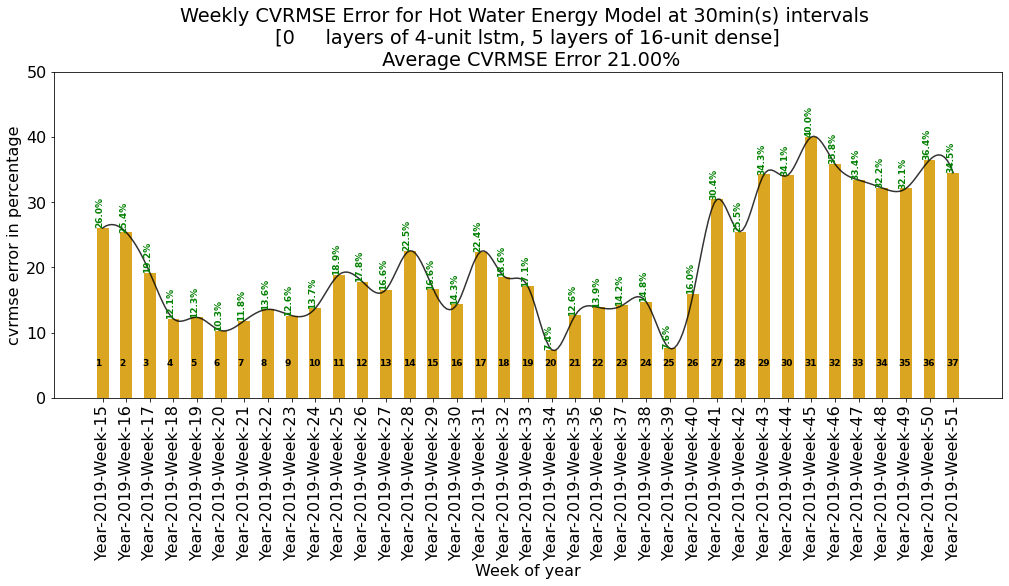

In [28]:
# Open a file
fo = open(path + "{}min Results_File.txt".format(5 * period), "r")
print("Name of the file: ", fo.name)
lines = fo.readlines()

parse_format = 'Year-{}-Week-{}-Time Step {}: {} RMSE={} |{} CVRMSE={} |{} MAE={}'
stats = {
    'Train': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    },
    'Test': {
        'rmse': [],
        'cvrmse': [],
        'mae': []
    }
}
xticklist = []
counter = 0
for line in lines:
    p = parse.parse(parse_format, line)
    stats[p[3]]['rmse'].append(float(p[4]))
    stats[p[5]]['cvrmse'].append(float(p[6]))
    stats[p[7]]['mae'].append(float(p[8]))
    if counter % 1 == 0:
        xticklist.append('Year-{}-Week-{}'.format(p[0], p[1]))
    counter += 1
fo.close()
cvrmse_list = stats['Test']['cvrmse']

max_cvrmse = max(cvrmse_list)
cvrmse_list = [i if i <= 30 else (10*(i-30)/(max_cvrmse-30))+30 for i in cvrmse_list]

cvrmse = sum(cvrmse_list) / len(cvrmse_list)
# from dataprocess import plotutils as pu
plot_args = dict(
    bars=cvrmse_list,
    color='goldenrod',
    bar_label='cvrmse',
    saveloc=path,
    smoothcurve=True,
    bar_annotate=True,
    saveplot=True,
    xlabel='Week of year',
    ylabel='cvrmse error in percentage',
    title=
    'Weekly CVRMSE Error for Hot Water Energy Model at {5:}min(s) intervals \n [{0:} \
    layers of {1:}-unit lstm, {2:} layers of {3:}-unit dense] \n Average CVRMSE Error {4:.2f}%'
    .format(modelconfig['lstm_no_layers'], modelconfig['lstm_hidden_units'],
            modelconfig['dense_no_layers'], modelconfig['dense_hidden_units'],
            cvrmse, 5 * period),
    xticklist=xticklist,
    plotwidth=17,
    plotheight=6,
    fontsize=16)
pu.single_bar_plot(**plot_args)

## Merge the pdfs together

In [26]:
# path where files are stored
pdfs_loc = path + 'detailedplots/'
# list all the files
flist = sorted(glob.glob(os.path.join(pdfs_loc, '*')))

In [27]:
from PyPDF2 import PdfFileMerger, PdfFileReader
 
# Call the PdfFileMerger
mergedObject = PdfFileMerger()
 
# I had 116 files in the folder that had to be merged into a single document
# Loop through all of them and append their pages
for filename in flist:
    mergedObject.append(PdfFileReader(filename, 'rb'))
    
#  Write all the files into a file which is named as shown below
mergedObject.write(path+'DetailedPredvsTarget.pdf')

### Code cemetery

In [ ]:
# from keras.utils import plot_model
# plot_model(nn_model.model, to_file='model.png',show_shapes=True,)


# # Check the trainable status of the individual layers
# for layer in nn_model.model.layers:
#     print(layer, layer.trainable, layer.name)


#model.model.summary()


#nn_model.model.layers[-1].input_shape
#model.model.layers[-1].kernel.initializer.run(session=K.get_session())
#model.model.layers[-1].bias.initializer.run(session=K.get_session())
#nn_model.model.layers[-1].output_shape